In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import pydicom as pdc
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf
import SimpleITK as sitk
import pandas as pd
import glob
import os
import shutil

## load patient number and disease

In [4]:
import pandas as pd
path = '../Code/benchmark_liver_tumor/raw/'
patient_meta = pd.read_csv(path + 'patient_meta.csv')
patient_meta = patient_meta[['RANDOM_PT_NO','SEX','AGE','PHASE',"DX"]]
patient_meta=patient_meta[['RANDOM_PT_NO','DX']]

## load label images

In [33]:
path = "./benchmark_liver_tumor/raw/"
folder_list = os.listdir(path)
img_folders=[]
for folder in folder_list:
    if not folder.endswith(".xlsx"):
        if "SN"in folder:
            img_folders.append(folder)

In [36]:
from PIL import Image
label_df = pd.DataFrame()
for folder in img_folders:
    label_list = os.listdir(path+folder+'/label/')
    idx = 0
    for image_name in label_list:
        im = Image.open(path+folder+'/label/'+image_name)
        image_name=image_name.split('.')[0].split('_')[-1]
        im = np.array(im)
        label_df=label_df.append(pd.Series([folder,image_name,im.mean()]),ignore_index=True)

In [37]:
label_df.columns = ['patient_no','img_idx','mean_annotation']
label_df.tail()

ValueError: Length mismatch: Expected axis has 3 elements, new values have 4 elements

In [105]:
patient_meta.head()

,RANDOM_PT_NO,DX
0,SN00180816,HCC
1,SN00361989,HCC
2,SN00481545,cholangiocarcinoma
3,SN00493709,cholangiocarcinoma
4,SN00181638,metastasis from pancreas


In [106]:
[dx for dx in np.unique(patient_meta['DX']) if 'metastasis' not in dx]

['HCC', 'NET', 'cholangiocarcinoma', 'lymphoma']

In [107]:
import collections
collections.Counter(patient_meta['DX'])

Counter({'HCC': 30,
         'cholangiocarcinoma': 14,
         'metastasis from pancreas': 14,
         'metastasis from stomach': 2,
         'metastasis from CBD': 1,
         'metastasis from breast': 9,
         'metastasis from colon': 5,
         'metastasis from lung': 14,
         'metastasis from uterus': 1,
         'metastasis from esophagus': 3,
         'metastasis from prostate': 1,
         'metastasis from choroidal melanoma': 2,
         'metastasis from unkown origin': 1,
         'NET': 2,
         'metastasis from cervix': 2,
         'lymphoma': 1,
         'metastasis from GB': 1})

## class 나누는 기준 (충분한 데이터가 있으면 클래스로, 아니면 기타로)
- 정상(annotation img 값이 모두 0): 0
- metastasis: 1
- HCC: 2
- cholangiocarcinoma: 3
- 기타(데이터 충분하지 않음): 삭제


In [11]:
def find_disease(patient_num):
    dx=np.array(patient_meta[patient_meta['RANDOM_PT_NO'] == patient_num]['DX'])[0]
    if 'metastasis'in dx:
        return 1
    elif dx == 'HCC':
        return 2
    elif dx == 'cholangiocarcinoma':
        return 3
    else:
        return 0   # 정상 ( 병변이 발견되지 않음 )
    
label_df['DX']=label_df.apply(lambda x: find_disease(x[0]) if float(x[2])>0.0 else -1, axis=1)

In [12]:
label_df.to_csv('metadata/label_df.csv',index = False)

# CNN

In [13]:
#  !pip install --upgrade tensorflow_hub

In [38]:
import pydicom as pdc
import matplotlib.pyplot as plt
from IPython.display import display, Image
import numpy as np
import cv2
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout
import tensorflow_hub as hub
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [41]:
total_patient=len(np.unique(label_df['patient_no']))
train_no=round(total_patient*0.7)
total_patient - train_no, train_no

(31, 72)

In [40]:
label_df = pd.read_csv('metadata/label_df.csv')
label_df

,patient_no,img_idx,mean_annotation,DX
0,SN00017916,1,0.0,0
1,SN00017916,2,0.0,0
2,SN00017916,3,0.0,0
3,SN00017916,4,0.0,0
4,SN00017916,5,0.0,0
...,...,...,...,...
14254,SN00563991,158,0.0,0
14255,SN00563991,159,0.0,0
14256,SN00563991,160,0.0,0
14257,SN00563991,161,0.0,0


In [46]:
## label_df 확인
label_df.loc[label_df['DX'] == 2]

,patient_no,img_idx,mean_annotation,DX
188,SN00037077,14,0.266533,2
189,SN00037077,15,1.713009,2
190,SN00037077,16,2.665329,2
191,SN00037077,17,3.314152,2
192,SN00037077,18,3.671150,2
...,...,...,...,...
13650,SN00527433,29,0.007782,2
14041,SN00553244,15,0.163422,2
14042,SN00553244,16,0.395908,2
14043,SN00553244,17,0.504856,2


In [42]:
train_patients=np.unique(label_df['patient_no'])[:train_no]
test_patients=np.unique(label_df['patient_no'])[train_no:]

In [43]:
def dcm2array(dcm_path, size=(128,128)):
    img = cv2.normalize(cv2.resize(pdc.dcmread(dcm_path).pixel_array, dsize=size), dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return img

def dcm2clahe2array(dcm_path, size=(128,128)):
    img = cv2.resize(pdc.dcmread(dcm_path).pixel_array, dsize=size)
    img = exposure.equalize_adapthist(img, clip_limit=0.03, nbins = 512)
    img = cv2.normalize(img, dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return img


X_train_pre = []
X_test_pre = []
def find_dcmfile(patient_no,img_idx):
    path = f'./benchmark_liver_tumor/raw/{patient_no}'
    folder_list = [img for img in os.listdir(path) if img.endswith('.dcm')]
    img_path = f'./benchmark_liver_tumor/raw/{patient_no}/{folder_list[img_idx-1]}'
    if patient_no in train_patients:
        X_train_pre.append(dcm2array(img_path))
    else:
        X_test_pre.append(dcm2array(img_path))
x=label_df.apply(lambda x: find_dcmfile(x[0],x[1]),axis=1)

In [50]:
Y=pd.get_dummies(label_df['DX'])
Y_train = Y[:len(X_train_pre)]
Y_test = Y[len(X_train_pre):]

In [51]:
X_train = np.expand_dims(np.array(X_train_pre),3)
X_test = np.expand_dims(np.array(X_test_pre),3)
X_train.shape,X_test.shape, Y_train.shape, Y_test.shape

((9905, 128, 128, 1), (4354, 128, 128, 1), (9905, 4), (4354, 4))

In [6]:
# save x (load image)
#np.save('models/np/X_train', X_train)
#np.save('models/np/X_test', X_test)
#np.save('models/np/Y_train', Y_train)
#np.save('models/np/Y_test', Y_test)


#load
X_train = np.load('models/np/X_train.npy')
X_test = np.load('models/np/X_test.npy')
Y_train = np.load('models/np/Y_train.npy')
Y_test = np.load('models/np/Y_test.npy')

In [110]:
# Build Model (2D-CNN)
cnn_input = tf.keras.Input((X_train.shape[1], X_train.shape[2],1))
h = tf.keras.layers.Reshape((X_train.shape[1], X_train.shape[2],1))(cnn_input)
h = tf.keras.layers.Conv2D(filters=16, kernel_size=(2, 2), padding='same', activation='relu')(h)
h = tf.keras.layers.MaxPool2D((2))(h)
h = tf.keras.layers.Conv2D(filters=16, kernel_size=(2, 2), padding='same', activation='relu')(h)
h = tf.keras.layers.MaxPool2D((2))(h)
h = tf.keras.layers.Conv2D(filters=16, kernel_size=(2, 2), padding='same', activation='relu')(h)
h = tf.keras.layers.MaxPool2D((2))(h)
h = tf.keras.layers.Conv2D(filters=16, kernel_size=(2, 2), padding='same', activation='relu')(h)
h = tf.keras.layers.MaxPool2D((2))(h)
h = tf.keras.layers.Dropout(0.2)(h)
h = tf.keras.layers.Flatten()(h)
h = tf.keras.layers.Dense(128, activation='relu')(h)
h = tf.keras.layers.Dense(64, activation='relu')(h)
cnn_output = tf.keras.layers.Dense(Y_train.shape[1], activation='softmax')(h)
cnn = tf.keras.Model(cnn_input, cnn_output)
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn.summary()

# display(Image(filename="./model/cnn.png"))

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 128, 128, 16)      80        
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 64, 16)        1040      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 16)       

In [111]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [123]:
# Train Model

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
cnn_history = cnn.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=30, shuffle=True, verbose=2, callbacks=[es])


Epoch 1/100
331/331 - 22s - loss: 0.4430 - accuracy: 0.8657 - val_loss: 0.4966 - val_accuracy: 0.8323
Epoch 2/100
331/331 - 22s - loss: 0.3192 - accuracy: 0.8819 - val_loss: 0.6375 - val_accuracy: 0.8319
Epoch 3/100
331/331 - 20s - loss: 0.2647 - accuracy: 0.8979 - val_loss: 0.6784 - val_accuracy: 0.8126
Epoch 4/100
331/331 - 19s - loss: 0.2239 - accuracy: 0.9117 - val_loss: 0.9101 - val_accuracy: 0.8222
Epoch 5/100
331/331 - 19s - loss: 0.1999 - accuracy: 0.9219 - val_loss: 0.8992 - val_accuracy: 0.8098
Epoch 6/100
331/331 - 20s - loss: 0.1694 - accuracy: 0.9303 - val_loss: 1.1087 - val_accuracy: 0.7827
Epoch 7/100
331/331 - 20s - loss: 0.1584 - accuracy: 0.9388 - val_loss: 1.3598 - val_accuracy: 0.8291
Epoch 8/100
331/331 - 20s - loss: 0.1372 - accuracy: 0.9436 - val_loss: 1.2517 - val_accuracy: 0.8277
Epoch 9/100
331/331 - 20s - loss: 0.1268 - accuracy: 0.9497 - val_loss: 1.0764 - val_accuracy: 0.8215
Epoch 10/100
331/331 - 20s - loss: 0.1095 - accuracy: 0.9557 - val_loss: 1.3720 - 

In [124]:
cnn.evaluate(X_test,Y_test)

137/137 [==============================] - 2s 16ms/step - loss: 2.2246 - accuracy: 0.8091


[2.224578619003296, 0.8091410398483276]

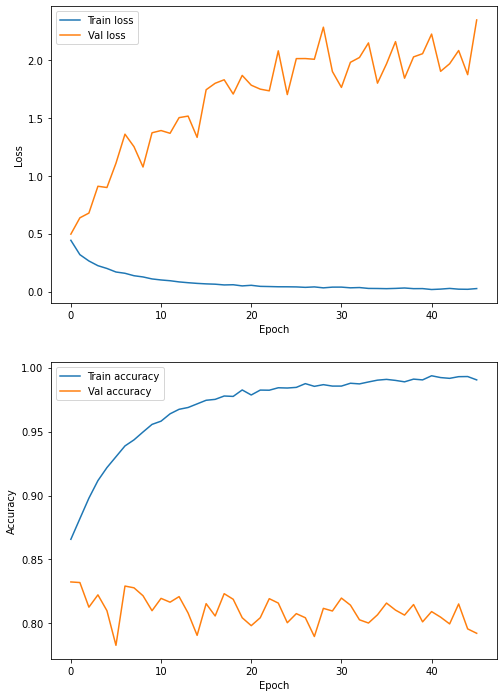

In [125]:
# visualize history
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
            label='Train loss')
    plt.plot(hist['epoch'], hist['val_loss'],
               label = 'Val loss')
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
            label='Train accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],
               label = 'Val accuracy')
    plt.legend()
plot_history(cnn_history)

### 모델 저장 및 로딩

In [6]:
# save model
#cnn.save("./models/basic_cnn2.h5")

# model load하는 경우
cnn  = tf.keras.models.load_model("./models/basic_cnn2.h5")

In [4]:
from sklearn.metrics import confusion_matrix


- 기타(데이터 충분하지 않음): 삭제 
- 정상(annotation img 값이 모두 0): 0
- metastasis: 1
- HCC: 2
- cholangiocarcinoma: 3

In [7]:
def output_class(x):
    output = np.argmax(x)
    if output == 0:
        return 'normal'
    elif output == 1:
        return 'metastasis'
    elif output == 2:
        return 'HCC'
    elif output == 3:
        return 'cholangiocarcinoma'

# X test 를 이용한 Y 값 예측    
y_pred = cnn.predict(X_test)    
y_true=pd.DataFrame(Y_test).apply(lambda x:output_class(x),axis=1)
y_pred_classified = pd.DataFrame(y_pred).apply(lambda x: output_class(x),axis=1)

In [8]:
Y_test.shape

(4354, 4)

In [9]:
y_pred.shape

(4354, 4)

### Confusion Matrix

In [10]:
print(confusion_matrix(y_true, y_pred_classified))

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classified))

[[   6   17   30  207]
 [   5    0   24  136]
 [  17    0   89  198]
 [  10    5  182 3428]]
                    precision    recall  f1-score   support

               HCC       0.16      0.02      0.04       260
cholangiocarcinoma       0.00      0.00      0.00       165
        metastasis       0.27      0.29      0.28       304
            normal       0.86      0.95      0.90      3625

          accuracy                           0.81      4354
         macro avg       0.32      0.32      0.31      4354
      weighted avg       0.75      0.81      0.77      4354



In [11]:
# X_train을 통한 예측값 비교
y_pred = cnn.predict(X_train)
y_true=pd.DataFrame(Y_train).apply(lambda x:output_class(x),axis=1)
y_pred_classified = pd.DataFrame(y_pred).apply(lambda x: output_class(x),axis=1)
print(confusion_matrix(y_true, y_pred_classified))

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classified))

[[ 405    0    0   10]
 [   0  201    0    1]
 [   0    0  716    6]
 [   8    0   31 8527]]
                    precision    recall  f1-score   support

               HCC       0.98      0.98      0.98       415
cholangiocarcinoma       1.00      1.00      1.00       202
        metastasis       0.96      0.99      0.97       722
            normal       1.00      1.00      1.00      8566

          accuracy                           0.99      9905
         macro avg       0.98      0.99      0.99      9905
      weighted avg       0.99      0.99      0.99      9905



## CAM(Class Activation Map)으로 나타내기

- https://www.sicara.ai/blog/2019-08-28-interpretability-deep-learning-tensorflow
- https://github.com/nickbiso/Keras-Class-Activation-Map/blob/master/Class%20Activation%20Map(CAM).ipynb

### example with dcm image

In [8]:
def dcm2array(dcm_path, size=(128,128)):
    img = cv2.normalize(cv2.resize(pdc.dcmread(dcm_path).pixel_array, dsize=size), dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return img

import numpy as np
import tensorflow as tf

layers_name = ['activation_1']
IMAGE_PATH = './benchmark_liver_tumor/raw/SN00017916/SN00017916_0021.dcm'

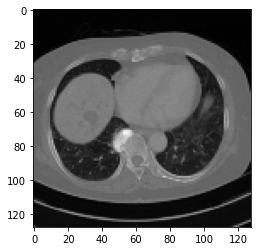

In [9]:
plt.imshow(dcm2array(IMAGE_PATH),cmap='gray')

In [10]:
# Model to examine
model = cnn

# Image to pass as input
img = dcm2array(IMAGE_PATH)

# Get the outputs of layers we want to inspect
outputs = [
    layer.output for layer in model.layers
    if layer.name in layers_name
]

# Create a connection between the input and those target outputs
activations_model = tf.keras.models.Model(model.inputs, outputs=outputs)
activations_model.compile(optimizer='adam', loss='categorical_crossentropy')

# Get their outputs
activations_1 = activations_model.predict(img)

In [11]:
model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 128, 128, 16)      80        
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 64, 16)        1040      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 16)       

In [12]:
label_df = pd.read_csv('metadata/label_df.csv')
label_df.head()
#label_df[:30]

,patient_no,img_idx,mean_annotation,DX
0,SN00017916,1,0.0,0
1,SN00017916,2,0.0,0
2,SN00017916,3,0.0,0
3,SN00017916,4,0.0,0
4,SN00017916,5,0.0,0


(<matplotlib.image.AxesImage at 0x13cbe488610>, (128, 128), (128, 128, 1))

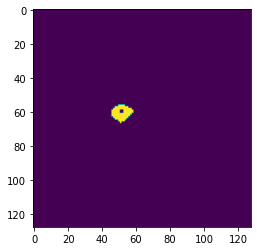

In [29]:
import cv2
import numpy as np
import tensorflow as tf

IMAGE_PATH = './benchmark_liver_tumor/raw/SN00017916/SN00017916_0021.dcm'
LAYER_NAME = 'conv2d_19'
CLASS_INDEX = 3

# Image to pass as input
img = dcm2array(IMAGE_PATH)

img = np.expand_dims(img, axis=2)
# img = np.expand_dims(img, axis=0)

# Create a graph that outputs target convolution and output
grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

# Get the score for target class
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.array([img]))
    loss = predictions[:, CLASS_INDEX]

# Extract filters and gradients
output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

# Average gradients spatially
weights = tf.reduce_mean(grads, axis=(0, 1))

# Build a ponderated map of filters according to gradients importance
cam = np.ones(output.shape[0:2], dtype=np.float32)

for index, w in enumerate(weights):
    cam += w * output[:, :, index]

# Heatmap visualization
cam = cv2.resize(cam.numpy(), (128, 128))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 0.003, 0)

plt.imshow(output_image[:,:,0]), output_image[:,:,0].shape, img.shape
#plt.imshow(output_image), output_image[:,:,0].shape, img.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


((128, 128, 1), (128, 128, 3), (128, 128, 3), (128, 128, 3))

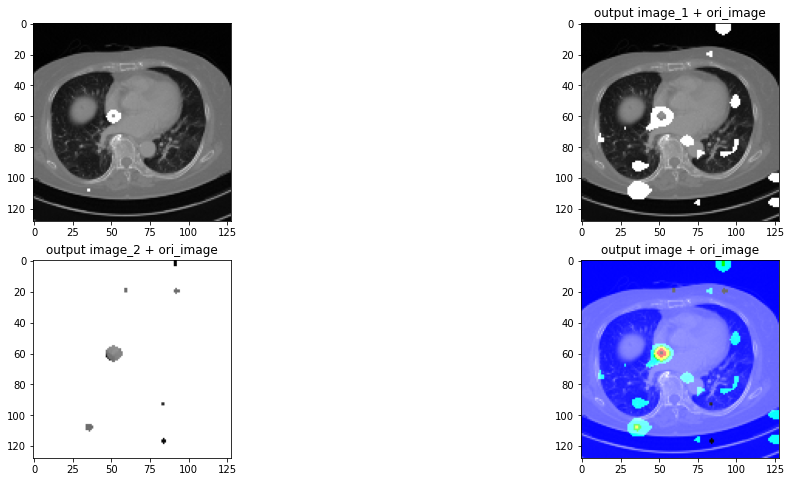

In [35]:
from PIL import Image


f, ax = plt.subplots(2,2,figsize=(18,8)) 
img = dcm2array(IMAGE_PATH)
#img = np.expand_dims(img, axis=2)
img = np.repeat(img[:, :, np.newaxis], 3, axis=2)  # 2차원 배열을 3차원으로 3번 복사 

# output 이미지에 원본사진을 더해줌
output = output_image[:,:,0]
output = np.expand_dims(output, axis=2)
output.shape
result=output+img
ax[0][1].set_title("output image_0 + ori_image")
ax[0][0].imshow(result,cmap='gray')

# output 이미지에 원본사진을 더해줌
output = output_image[:,:,1]
output = np.expand_dims(output, axis=2)
output.shape
result=output+img
ax[0][1].set_title("output image_1 + ori_image")
ax[0][1].imshow(result,cmap='gray')

# output 이미지에 원본사진을 더해줌
output = output_image[:,:,2]
output = np.expand_dims(output, axis=2)
output.shape
result=output+img
ax[1][0].set_title("output image_2 + ori_image")
ax[1][0].imshow(result,cmap='gray')

# output 이미지에 원본사진을 더해줌
img = dcm2array(IMAGE_PATH)
img = np.expand_dims(img, axis=2)
result=output_image+img
ax[1][1].imshow(result,cmap='gray')
ax[1][1].set_title("output image + ori_image")

#plt.show()
img.shape, output_image.shape, result.shape, output_image[:].shape

(<matplotlib.image.AxesImage at 0x13cc08c33a0>, (128, 128), (128, 128, 1))

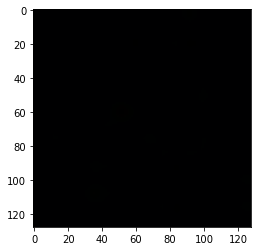

In [34]:
import cv2
import numpy as np
import tensorflow as tf

IMAGE_PATH = './benchmark_liver_tumor/raw/SN00017916/SN00017916_0014.dcm'
LAYER_NAME = 'conv2d_19'
CLASS_INDEX = 3

# Image to pass as input
img = dcm2array(IMAGE_PATH)

img = np.expand_dims(img, axis=2)
# img = np.expand_dims(img, axis=0)

# Create a graph that outputs target convolution and output
grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

# Get the score for target class
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.array([img]))
    loss = predictions[:, CLASS_INDEX]

# Extract filters and gradients
output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

# Average gradients spatially
weights = tf.reduce_mean(grads, axis=(0, 1))

# Build a ponderated map of filters according to gradients importance
cam = np.ones(output.shape[0:2], dtype=np.float32)

for index, w in enumerate(weights):
    cam += w * output[:, :, index]

# Heatmap visualization
cam = cv2.resize(cam.numpy(), (128, 128))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 0.003, 0)

plt.imshow(output_image), output_image[:,:,0].shape, img.shape
#plt.imshow(output_image), output_image[:,:,0].shape, img.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'output image + ori_image')

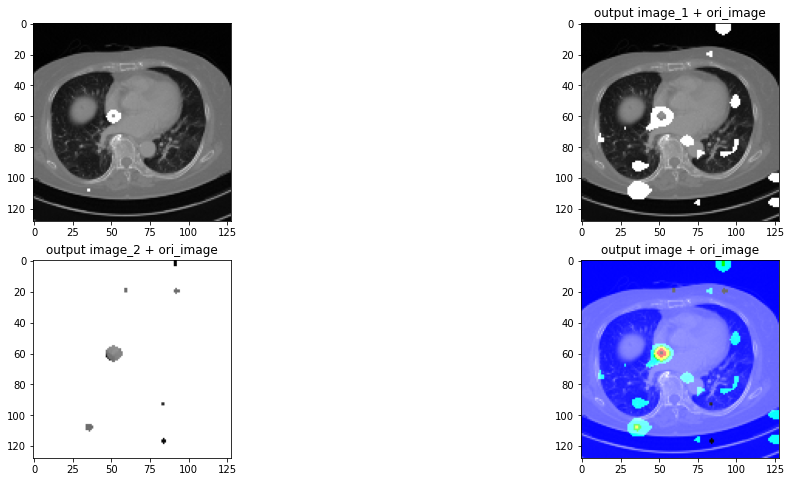

In [309]:
from PIL import Image


f, ax = plt.subplots(2,2,figsize=(18,8)) 
img = dcm2array(IMAGE_PATH)
#img = np.expand_dims(img, axis=2)
img = np.repeat(img[:, :, np.newaxis], 3, axis=2)  # 2차원 배열을 3차원으로 3번 복사 

# output 이미지에 원본사진을 더해줌
output = output_image[:,:,0]
output = np.expand_dims(output, axis=2)
output.shape
result=output+img
ax[0][1].set_title("output image_0 + ori_image")
ax[0][0].imshow(result,cmap='gray')

# output 이미지에 원본사진을 더해줌
output = output_image[:,:,1]
output = np.expand_dims(output, axis=2)
output.shape
result=output+img
ax[0][1].set_title("output image_1 + ori_image")
ax[0][1].imshow(result,cmap='gray')

# output 이미지에 원본사진을 더해줌
output = output_image[:,:,2]
output = np.expand_dims(output, axis=2)
output.shape
result=output+img
ax[1][0].set_title("output image_2 + ori_image")
ax[1][0].imshow(result,cmap='gray')

# output 이미지에 원본사진을 더해줌
img = dcm2array(IMAGE_PATH)
img = np.expand_dims(img, axis=2)
result=output_image+img
ax[1][1].imshow(result,cmap='gray')
ax[1][1].set_title("output image + ori_image")

#plt.show()
#img.shape, output_image.shape, result.shape, output_image[:].shape

### example with cat image

In [112]:
def dcm2array(dcm_path, size=(128,128)):
    img = cv2.normalize(cv2.resize(pdc.dcmread(dcm_path).pixel_array, dsize=size), dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return img

In [113]:
import numpy as np
import tensorflow as tf

layers_name = ['activation_1']
IMAGE_PATH = './cat.jpg'

# Model to examine
model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=True)

# Image to pass as input
img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)

# Get the outputs of layers we want to inspect
outputs = [
    layer.output for layer in model.layers
    if layer.name in layers_name
]

# Create a connection between the input and those target outputs
activations_model = tf.keras.models.Model(model.inputs, outputs=outputs)
activations_model.compile(optimizer='adam', loss='categorical_crossentropy')

# Get their outputs
activations_1 = activations_model.predict(np.array([img]))

102973440/102967424 [==============================] - 18s 0us/step


FileNotFoundError: [Errno 2] No such file or directory: './cat.jpg'

In [ ]:
import numpy as np
import tensorflow as tf

# Layer name to inspect
layer_name = 'block3_conv1'

epochs = 100
step_size = 1.
filter_index = 0

# Create a connection between the input and the target layer
model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)
submodel = tf.keras.models.Model([model.inputs[0]], [model.get_layer(layer_name).output])

# Initiate random noise
input_img_data = np.random.random((1, 224, 224, 3))
input_img_data = (input_img_data - 0.5) * 20 + 128.

# Cast random noise from np.float64 to tf.float32 Variable
input_img_data = tf.Variable(tf.cast(input_img_data, tf.float32))

# Iterate gradient ascents
for _ in range(epochs):
    with tf.GradientTape() as tape:
        outputs = submodel(input_img_data)
        loss_value = tf.reduce_mean(outputs[:, :, :, filter_index])
    grads = tape.gradient(loss_value, input_img_data)
    normalized_grads = grads / (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)
    input_img_data.assign_add(normalized_grads * step_size)

In [ ]:

import numpy as np
import tensorflow as tf

# Create function to apply a grey patch on an image
def apply_grey_patch(image, top_left_x, top_left_y, patch_size):
    patched_image = np.array(image, copy=True)
    patched_image[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size, :] = 127.5

    return patched_image

# Load image
IMAGE_PATH = './cat.jpg'
img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)

# Instantiate model
model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=True)

CAT_CLASS_INDEX = 281  # Imagenet tabby cat class index
PATCH_SIZE = 40

sensitivity_map = np.zeros((img.shape[0], img.shape[1]))

# Iterate the patch over the image
for top_left_x in range(0, img.shape[0], PATCH_SIZE):
    for top_left_y in range(0, img.shape[1], PATCH_SIZE):
        patched_image = apply_grey_patch(img, top_left_x, top_left_y, PATCH_SIZE)
        predicted_classes = model.predict(np.array([patched_image]))[0]
        confidence = predicted_classes[CAT_CLASS_INDEX]
        
        # Save confidence for this specific patched image in map
        sensitivity_map[
            top_left_y:top_left_y + PATCH_SIZE,
            top_left_x:top_left_x + PATCH_SIZE,
        ] = confidence

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

IMAGE_PATH = './cat.jpg'
LAYER_NAME = 'block5_conv3'
CAT_CLASS_INDEX = 281

img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)

# Load initial model
model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)

# Create a graph that outputs target convolution and output
grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

# Get the score for target class
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.array([img]))
    loss = predictions[:, CAT_CLASS_INDEX]

# Extract filters and gradients
output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

# Average gradients spatially
weights = tf.reduce_mean(grads, axis=(0, 1))

# Build a ponderated map of filters according to gradients importance
cam = np.ones(output.shape[0:2], dtype=np.float32)

for index, w in enumerate(weights):
    cam += w * output[:, :, index]

# Heatmap visualization
cam = cv2.resize(cam.numpy(), (224, 224))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 1, 0)


In [ ]:
plt.imshow(output_image)

In [ ]:
from PIL import Image
original_img = Image.open('./cat.jpg')
original_img = np.array(original_img)
plt.imshow(original_img)